In [2]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.special import logsumexp

In [3]:
cuda2 = False # torch.cuda.is_available() can be used to check if a gpu is available 
batch_size2 = 128
log_interval2 = 10
epochs2 = 25 

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda2 else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)

In [4]:
# define model

kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 2 # latent dimension for sampling


# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d( in_channels=image_channels, out_channels=init_channels, 
                    kernel_size=kernel_size, stride=2, padding=1)
        self.enc2 = nn.Conv2d(in_channels=init_channels, out_channels=init_channels*2,
                    kernel_size=kernel_size, stride=2, padding=1)
        self.enc3 = nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, 
                    kernel_size=kernel_size, stride=2, padding=1)
        self.enc4 = nn.Conv2d(in_channels=init_channels*4, out_channels=64, 
                    kernel_size=kernel_size, stride=2, padding=1)
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(in_channels=64, out_channels=init_channels*8, 
            kernel_size=kernel_size, stride=1, padding=0)
        self.dec2 = nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, 
            kernel_size=kernel_size, stride=2, padding=1)
        self.dec3 = nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2,
                kernel_size=kernel_size, stride=2, padding=1)
        self.dec4 = nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=image_channels, 
            kernel_size=kernel_size, stride=2, padding=3)
    
    
    def encode(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        return mu, log_var
    
    def decode(self, z):
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction
    

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        #encoding
        mu, logvar = self.encode(x)
        #reparameterize
        z = self.reparameterize(mu, logvar)
        #decoding
        out = self.decode(z)
        return out, mu, logvar

In [5]:
# define loss, train and test function + train model

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train(epoch):
    model.train() # so that everything has gradients and we can do backprop and so on...
    train_loss = 0
    a=0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step()# backpropagation
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print(data.shape, len(test_loader.dataset))
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss


print(batch_size2)
train_loss_list = []
test_loss_list = []
for epoch in range(1, epochs2 + 1):
    train_loss_list.append(train(epoch))
    test_loss_list.append(test(epoch))
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   './sample_' + str(epoch) + '.png')

128
====> Epoch: 1 Average loss: 207.7618
torch.Size([16, 1, 28, 28]) 10000
====> Test set loss: 170.5559
====> Epoch: 2 Average loss: 164.0898
torch.Size([16, 1, 28, 28]) 10000
====> Test set loss: 160.3767
====> Epoch: 3 Average loss: 157.9825
torch.Size([16, 1, 28, 28]) 10000
====> Test set loss: 156.1858
====> Epoch: 4 Average loss: 155.0073
torch.Size([16, 1, 28, 28]) 10000
====> Test set loss: 153.7283
====> Epoch: 5 Average loss: 152.8010
torch.Size([16, 1, 28, 28]) 10000
====> Test set loss: 151.8681
====> Epoch: 6 Average loss: 151.2811
torch.Size([16, 1, 28, 28]) 10000
====> Test set loss: 150.4688
====> Epoch: 7 Average loss: 150.1812
torch.Size([16, 1, 28, 28]) 10000
====> Test set loss: 149.6651
====> Epoch: 8 Average loss: 149.3103
torch.Size([16, 1, 28, 28]) 10000
====> Test set loss: 148.9292
====> Epoch: 9 Average loss: 148.5498
torch.Size([16, 1, 28, 28]) 10000
====> Test set loss: 147.8959
====> Epoch: 10 Average loss: 147.8406
torch.Size([16, 1, 28, 28]) 10000
====>

torch.Size([64, 1, 28, 28])


<function matplotlib.pyplot.show(*args, **kw)>

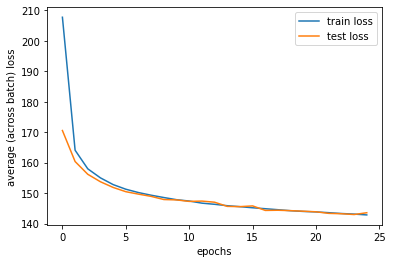

In [6]:
print(sample.shape)
# plot training and test loss

plt.plot(np.arange(epochs2), train_loss_list, label="train loss")
plt.plot(np.arange(epochs2), test_loss_list, label="test loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("average (across batch) loss")
plt.show

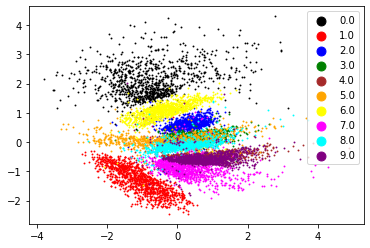

In [8]:
# plot scatter plot

mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((batch_size2*B,2))
all_labels = torch.empty(0)
l = 0

for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:].view(1,1,28,28)
        mean_img = model.encode(an_img)[0]
        results[l] = mean_img
        l +=1
results = results[:l,:]
all_labels = all_labels[:l]

results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
    ax.legend(markerscale = 10)
plt.show()

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


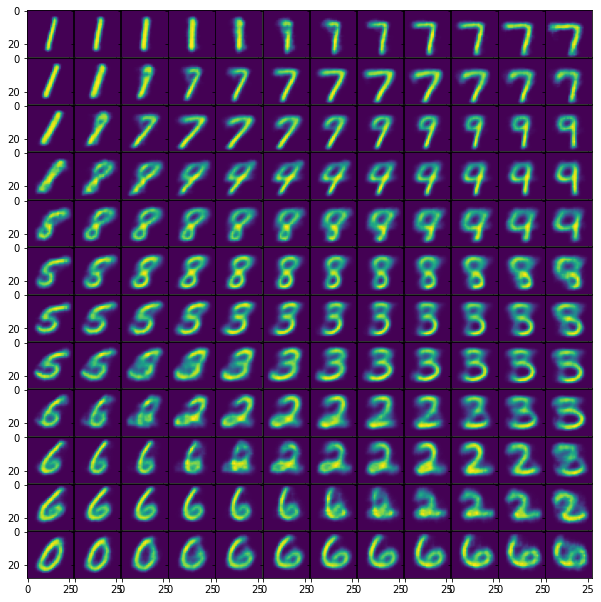

In [9]:
# plot digits

M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]

mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
gauss_x = gauss.icdf(mesh_x)#.flip(0)
gauss_y = gauss.icdf(mesh_y)


fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i,j].item()
        y_val = gauss_y[i,j].item()
        im = model.decode(torch.Tensor([y_val, x_val]))
        im_plt = im.reshape((28,28))
        plot_me = im_plt.detach().numpy()
        ax[i,j].imshow(plot_me)

slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.show()